In [1]:
import s3fs
import boto3
import time

from PIL import Image
import numpy as np
import hashlib
import io
import json
import gc

import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms, models
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, accuracy_score

In [2]:
def init_clients():
    return boto3.client("s3"), s3fs.S3FileSystem()

boto3_s3, s3fs_ = init_clients()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [4]:
def data_loading(path):
    with open(path, 'r') as file:
        test_data = json.load(file)
    x = list(test_data.keys())
    y = list(test_data.values())
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42,stratify=y)
    return train_x, test_x, train_y, test_y

In [5]:
def data_loading_COMPCAR():
    train_x, test_x, train_y, test_y = data_loading('TESTDATA.json')

    with open('COMPCAR.json', 'r') as file:
        test_data = json.load(file)
    x = list(test_data.keys())
    y = list(test_data.values())
    train_x_2, test_x_2, train_y_2, test_y_2 = train_test_split(x, y, test_size=0.90, random_state=42,stratify=y)

    train_x.extend(train_x_2)
    train_y.extend(train_y_2)
    
    test_x.extend(test_x_2[:1500])
    test_y.extend(test_y_2[:1500])
    return train_x, test_x, train_y, test_y

In [6]:
def preprocess_image(image_bytes):
    # Open the image as bytes
    image = Image.open(io.BytesIO(image_bytes))

    # Convert to grayscale
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Convert image to numpy array
    image_np = np.array(image)

    # Convert the numpy array to PyTorch tensor
    image_tensor = torch.tensor(image_np)

    # Convert the tensor to 3D RGB (if it's not already)
    if len(image_tensor.shape) == 2:
        image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    image_tensor = image_tensor.permute(2, 0, 1)  # Convert HWC to CHW

    # Normalize to [0, 1]
    image_tensor = image_tensor.float() / 255.0

    return image_tensor


def process_duplicates_image_ids(model, image_paths: list, batch_size: int,
                                 bucket: str, boto_s3: boto3.client("s3"), 
                                 s3fs_: s3fs.S3FileSystem(), target_size=(256, 256)):
    models = ['ResNet','VGG16', 'SVM', 'YOLO']
    if model in models:
        preprocess = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor(),])

    image_tensors = []
    for i in range(0, len(image_paths), batch_size):
        batch_image_paths = image_paths[i:i + batch_size]
        batch_image_tensors = []
        for ad_image in batch_image_paths:
            if ad_image.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = "/".join(ad_image.split("/")[1:])
                s3_object = boto_s3.get_object(Bucket=bucket, Key=image_path)
                image_bytes = s3_object['Body'].read()
                image_tensor = preprocess_image(image_bytes)
                batch_image_tensors.append(image_tensor)
        # Resize or crop images to the target size before stacking
        batch_image_tensors_resized = [transforms.functional.resize(image, target_size) for image in batch_image_tensors]
        image_tensors.append(torch.stack(batch_image_tensors_resized))

    # Concatenate processed batches
    processed_image_tensors = torch.cat(image_tensors, dim=0)

    # Display the shape and dtype of the tensor
    print("Tensor Shape:", processed_image_tensors.shape)
    print("Tensor Dtype:", processed_image_tensors.dtype)

    return processed_image_tensors

In [7]:
def run_svm(im_train,train_y,im_test,test_y):
    start_time = time.time()

    im_train_svm = im_train
    train_y_svm = train_y

    im_test_svm = im_test
    test_y_svm = test_y

    # Flatten the tensors
    train_x_flattened = im_train_svm.view(im_train_svm.size(0), -1).numpy()
    test_x_flattened = im_test_svm.view(im_test_svm.size(0), -1).numpy()

    # Feature scaling for better performance
    scaler = StandardScaler()
    train_x_scaled = scaler.fit_transform(train_x_flattened)
    test_x_scaled = scaler.transform(test_x_flattened)

    svm_classifier = SVC(kernel='rbf', random_state=42)
    print('FITTING')
    svm_classifier.fit(train_x_scaled, train_y_svm)
    print('FITTING DONE')
    end_time = time.time()
    print("Time taken for training:", end_time - start_time, "seconds")
    start_time = time.time()
    y_pred = svm_classifier.predict(test_x_scaled)
    end_time = time.time()
    print("Time taken for testing:", end_time - start_time, "seconds")
    return y_pred

In [8]:
def show_matrix(test_y_svm,y_pred,filename=None):
    print(classification_report(test_y_svm, y_pred))
    cm = confusion_matrix(test_y_svm, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['interior','exterior'])
    disp.plot()
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

In [9]:
def main_SVM():
    train_x, test_x, train_y, test_y = data_loading_COMPCAR()
    gc.collect()
    im_train = process_duplicates_image_ids('SVM',image_paths=train_x,batch_size=100,bucket="s3-path",
            boto_s3=boto3_s3,
            s3fs_=s3fs_)

    im_test = process_duplicates_image_ids('SVM',image_paths=test_x,batch_size=100,bucket="s3-path",
            boto_s3=boto3_s3,
            s3fs_=s3fs_)

    pred = run_svm(im_train,train_y,im_test,test_y)
    show_matrix(test_y,pred,filename='SVM_results.png')

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Tensor Shape: torch.Size([5324, 3, 256, 256])
Tensor Dtype: torch.float32
Tensor Shape: torch.Size([2661, 3, 256, 256])
Tensor Dtype: torch.float32
FITTING
FITTING DONE
Time taken for training: 504.8697392940521 seconds
Time taken for testing: 2599.405337333679 seconds
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1477
           1       0.87      0.83      0.85      1184

    accuracy                           0.87      2661
   macro avg       0.87      0.86      0.86      2661
weighted avg       0.87      0.87      0.87      2661



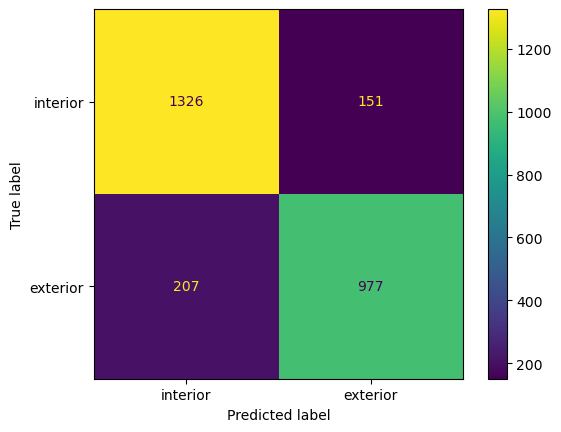

In [15]:
main_SVM()

# SVM as classifier

In [10]:
def data_loading(path):
    with open(path, 'r') as file:
        test_data = json.load(file)
    x = list(test_data.keys())
    y = list(test_data.values())
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42,stratify=y)
    return train_x, test_x, train_y, test_y

In [11]:
def fit_train_embeddings(im_train,train_y):
    start_time = time.time()
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights).to(device)
    model.eval()


    data_loader = DataLoader(im_train, batch_size=32, shuffle=False)
    embeddings = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            embedding_batch = model(batch)
            embeddings.append(embedding_batch)

    train_embeddings = torch.cat(embeddings, dim=0).cpu().numpy()
    
    svm_classifier = SVC(kernel='rbf', random_state=42)
    svm_classifier.fit(train_embeddings, train_y)
    end_time = time.time()
    print("Time taken for training:", end_time - start_time, "seconds")
    return svm_classifier

In [12]:
def predict_test_embeddings(im_test,svm_classifier):
    start_time = time.time()
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights).to(device)
    model.eval()


    data_loader = DataLoader(im_test, batch_size=32, shuffle=False)
    embeddings = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            embedding_batch = model(batch)
            embeddings.append(embedding_batch)

    embeddings_test = torch.cat(embeddings, dim=0).cpu().numpy()
    y_pred = svm_classifier.predict(embeddings_test)
    end_time = time.time()
    print("Time taken for testing:", end_time - start_time, "seconds")
    return y_pred

In [13]:
def trained_SVM():
    train_x, test_x, train_y, test_y = data_loading_COMPCAR()
    gc.collect()
    im_train = process_duplicates_image_ids('ResNet',image_paths=train_x,batch_size=100,bucket="s3-path",
            boto_s3=boto3_s3,
            s3fs_=s3fs_)
    im_test = process_duplicates_image_ids('ResNet',image_paths=test_x,batch_size=100,bucket="s3-path",
            boto_s3=boto3_s3,
            s3fs_=s3fs_)

    svm_classifier = fit_train_embeddings(im_train,train_y)
    result = predict_test_embeddings(im_test,svm_classifier)
    show_matrix(test_y,result,filename='trained_SVM_classifier_results.png')

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Tensor Shape: torch.Size([5324, 3, 256, 256])
Tensor Dtype: torch.float32
Tensor Shape: torch.Size([2661, 3, 256, 256])
Tensor Dtype: torch.float32


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 228MB/s]


Time taken for training: 22.53481101989746 seconds
Time taken for testing: 10.317439794540405 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1477
           1       0.99      0.98      0.99      1184

    accuracy                           0.99      2661
   macro avg       0.99      0.99      0.99      2661
weighted avg       0.99      0.99      0.99      2661



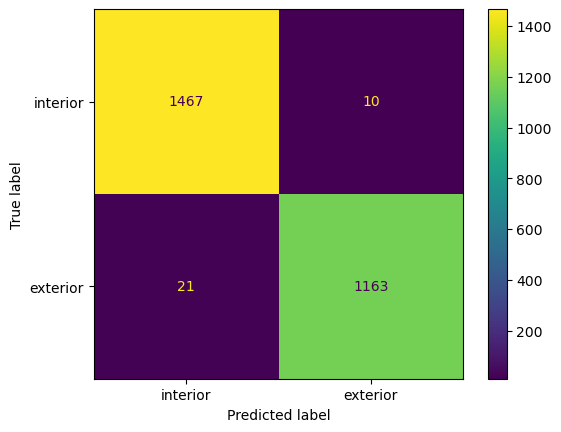

In [17]:
trained_SVM()

In [14]:
train_x, test_x, train_y, test_y = data_loading_COMPCAR()

misclassified_indices = []
for i in range(len(test_y)):
    if test_y[i] != result[i]:
        misclassified_indices.append(i)
        
misclassified_indices


[139,
 158,
 213,
 281,
 301,
 306,
 355,
 412,
 474,
 491,
 561,
 591,
 620,
 622,
 641,
 701,
 712,
 736,
 878,
 887,
 957,
 963,
 978,
 1007,
 1097,
 1101,
 1143]

In [15]:
resn = [13,
 14,
 213,
 281,
 297,
 301,
 306,
 342,
 382,
 440,
 446,
 473,
 474,
 491,
 534,
 547,
 561,
 591,
 620,
 622,
 641,
 678,
 701,
 712,
 736,
 744,
 747,
 759,
 806,
 878,
 891,
 963,
 981,
 1004,
 1097,
 1113,
 1143]

In [16]:
overlap = set(misclassified_indices) & set(resn)
overlap

{213,
 281,
 301,
 306,
 474,
 491,
 561,
 591,
 620,
 622,
 641,
 701,
 712,
 736,
 878,
 963,
 1097,
 1143}

In [18]:
accuracy_score(test_y,result)

0.9767441860465116

In [17]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.fc

Linear(in_features=2048, out_features=1000, bias=True)